In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import get_window

In [3]:
files = {
    'sig1': { 'wi': 1000 , 'ov': 75, 'time_points': [300, 500, 400, 600, 750] },
    'sig2': { 'wi': 800 , 'ov': 60, 'time_points': [300, 700, 1000, 2620, 2900] },
    'sig3': { 'wi': 800 , 'ov': 60, 'time_points': [100, 560, 1530, 2620, 3000] },
}

In [4]:
def sdft(signal: np.array, fs: int, window_size_ms: int, overlap_percentage: float, use_hamming: bool = False):
    wi = int(np.round((window_size_ms / 1000) * fs))
    ov = int(np.round(wi * (overlap_percentage / 100)))
    padded_signal = np.pad(signal, (0, wi), mode='constant')
    jump_size = wi - ov

    N = len(padded_signal)
    freq = np.linspace(0, fs, wi)

    num_windows = (N - wi) // jump_size
    t = np.arange(num_windows) * jump_size / fs
    specgram = np.zeros((len(freq), num_windows), dtype=complex)
    window = get_window('hamming', wi) if use_hamming else np.ones(wi)

    for i in range(num_windows):
        start = i * jump_size
        segment = padded_signal[start:start+wi] * window
        specgram[:, i] = np.fft.fft(segment)[:len(freq)]
    return freq, t, specgram

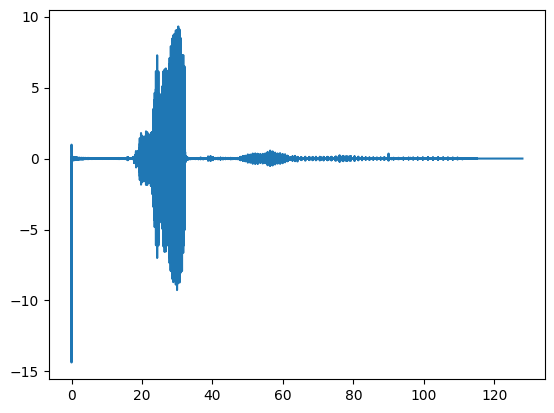

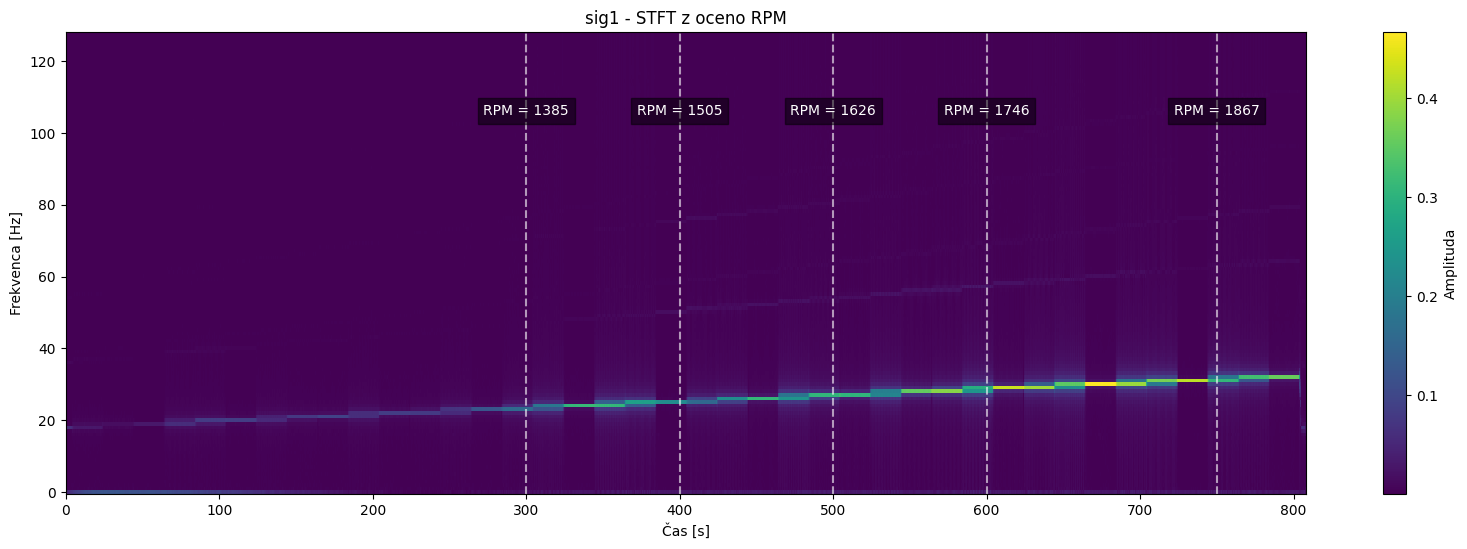

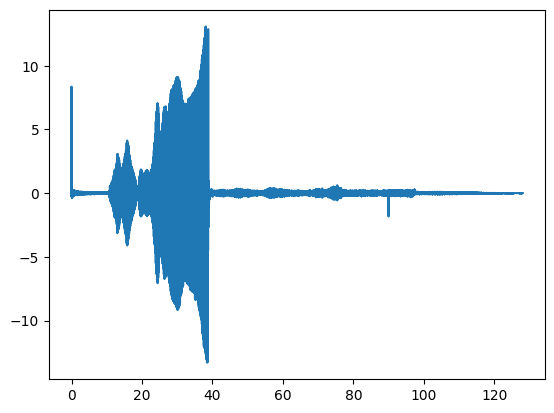

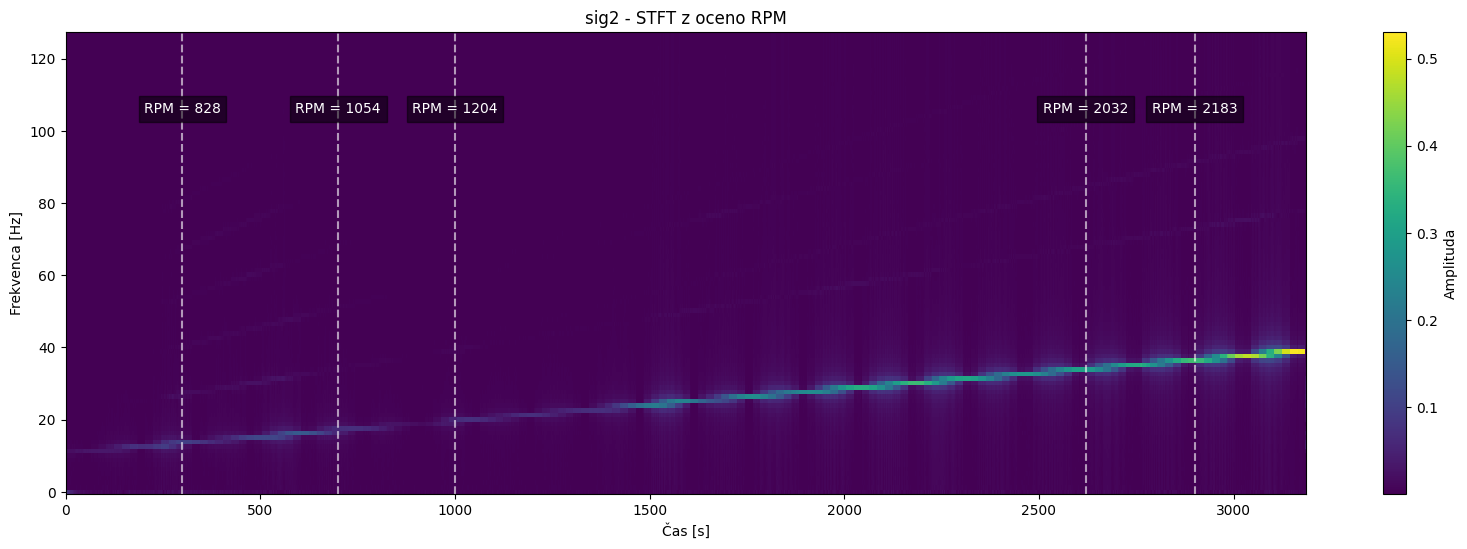

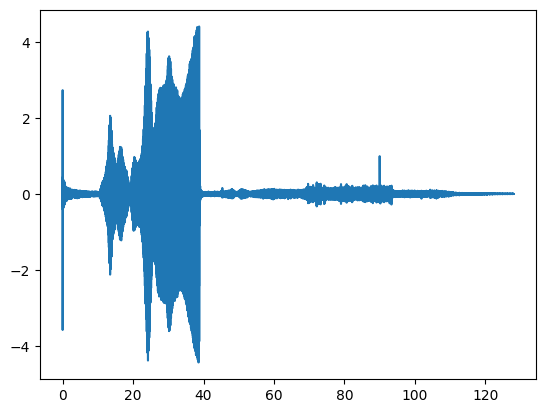

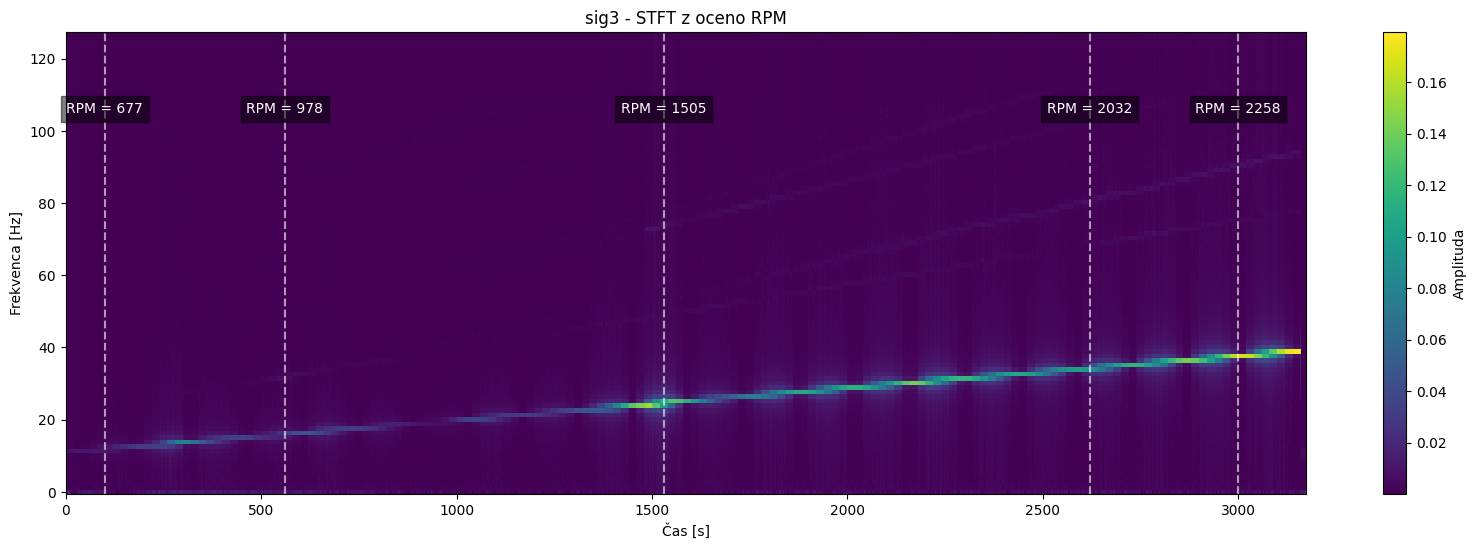

In [7]:
Fs = 256  # Sampling frequency

for file in files:
    wi = files[file]['wi']
    ov = files[file]['ov']
    time_points = files[file]['time_points']

    signal = np.loadtxt(f'data/{file}.csv', dtype=np.float64, delimiter=',')
    signal -= np.mean(signal)

    fr, ti, sp = sdft(signal, Fs, window_size_ms=wi, overlap_percentage=ov, use_hamming=False)
    half_n_freqs = sp.shape[0]//2
    sp = sp[:half_n_freqs, :]
    fr = fr[:half_n_freqs]

    dominant_freqs = fr[np.argmax(np.abs(sp), axis=0)]
    estimated_rpm = dominant_freqs * 60

    plt.figure(figsize=(20, 6))
    plt.pcolormesh(ti, fr, np.abs(sp), shading='auto')
    plt.title(f'{file} - STFT z oceno RPM')
    plt.xlabel('Čas [s]')
    plt.ylabel('Frekvenca [Hz]')
    plt.colorbar(label='Amplituda')

    for t in time_points:
        idx = np.argmin(np.abs(ti - t))
        rpm = estimated_rpm[idx]
        plt.axvline(x=t, color='white', linestyle='--', alpha=0.6)
        plt.text(t, Fs // 2 - 20, f'RPM = {int(rpm)}', color='white', ha='center', va='top',  fontsize=10, bbox=dict(facecolor='black', alpha=0.5))

    plt.show()